In [ ]:
import xarray as xr
import numpy as np
import scipy.ndimage
from skimage.measure import regionprops 
from skimage.measure import label as label_np
import dask.array as dsa

import matplotlib.pyplot as plt

In [ ]:
# file_path = '/glade/scratch/scanh/MHW_pre/preprocess_mhw_OISST_monthly_noTrend_stn_quarterdegree_global.nc'
file_path = '/glade/scratch/scanh/MHW_pre/preprocess_mhw_OISSTv2_monthly_notrend_stn.nc'
ds = xr.open_dataset(file_path, decode_times=True)

da = ds.mhw_ssta_notrend
radius = 8
min_size_quartile = 0.75

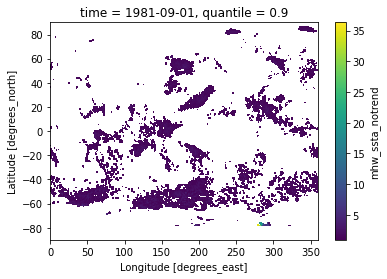

In [ ]:
da[0,:,:].plot()

## 1. Morphological Operations

In [ ]:
# Convert images to binary. All positive values == 1, otherwise == 0
bitmap_binary = da.where(da>0, drop=False, other=0)
bitmap_binary = bitmap_binary.where(bitmap_binary==0, drop=False, other=1)
    
# Define structuring element
diameter = radius*2
x = np.arange(-radius, radius+1)
x, y = np.meshgrid(x, x)
r = x**2+y**2 
se = r<radius**2

def binary_open_close(bitmap_binary):
    bitmap_binary_padded = np.pad(bitmap_binary,
                                      ((diameter, diameter), (diameter, diameter)),
                                      mode='wrap')
    s1 = scipy.ndimage.binary_closing(bitmap_binary_padded, se, iterations=1)
    s2 = scipy.ndimage.binary_opening(s1, se, iterations=1)
    unpadded= s2[diameter:-diameter, diameter:-diameter]
    return unpadded
    
mo_binary = xr.apply_ufunc(binary_open_close, bitmap_binary,
                               input_core_dims=[['lat', 'lon']],
                               output_core_dims=[['lat', 'lon']],
                               output_dtypes=[bitmap_binary.dtype],
                               vectorize=True,
                               dask='parallelized')

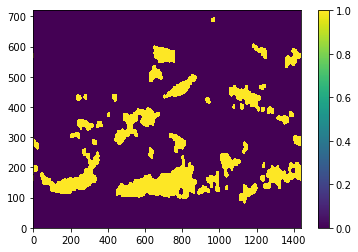

In [ ]:
plt.pcolormesh(mo_binary[0,:,:]); plt.colorbar()

## 2. Label

In [ ]:
def _label_either(data, **kwargs):
    if isinstance(data, dsa.Array):
        try:
            from dask_image.ndmeasure import label as label_dask
            def label_func(a, **kwargs):
                ids, num = label_dask(a, **kwargs)
                return ids
        except ImportError:
            raise ImportError(
                "Dask_image is required to use this function on Dask arrays. "
                "Either install dask_image or else call .load() on your data."
            )
    else:
        label_func = label_np
    return label_func(data, **kwargs)

labels, num = _label_either(mo_binary, return_num= True, connectivity=3)


## 3. Wrap Labels

In [ ]:
first_column = labels[..., 0]
last_column = labels[..., -1]
    
unique_first = np.unique(first_column[first_column>0])
    
# This loop iterates over the unique values in the first column, finds the location of those values in 
# the first columnm and then uses that index to replace the values in the last column with the first column value
for i in enumerate(unique_first):
    new_ID = np.where(first_column == i[1])
    bad_labels = np.unique(last_column[new_ID[0], new_ID[1]])
    labels = np.where(labels == bad_labels, i[1], labels)

new_labels = np.unique(labels, return_inverse=True)[1].reshape(labels.shape)
    
# recalculate the total number of labels 
N = np.max(new_labels)


<ipython-input-65-989c9f67ac4f>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  labels = np.where(labels == bad_labels, i[1], labels)


## 4. Filter Area

In [ ]:
# Label
unique_labels, num = xr.apply_ufunc(
        label_np, 
        mo_binary,
        kwargs={'return_num': True, 'connectivity': 2},
        input_core_dims=[['lat', 'lon', ]],
        output_core_dims=[['lat', 'lon'], []],
        output_dtypes=['i4', 'i4'],
        dask='parallelized',
        vectorize=True
    )

    
offset = num.cumsum().shift(time=1, fill_value=0)
unique_labels = xr.where(unique_labels > 0, unique_labels + offset, 0)

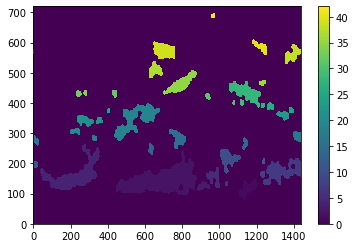

In [ ]:
plt.pcolormesh(unique_labels[0,:,:]); plt.colorbar()

In [ ]:
props = regionprops(unique_labels.values.astype('int'))
labelprops = [p.label for p in props]
labelprops = xr.DataArray(labelprops, dims=['label'], coords={'label': labelprops}) 
area = area = xr.DataArray([p.area for p in props], dims=['label'], coords={'label': labelprops})  # Number of pixels of the region.
min_area = np.percentile(area, min_size_quartile*100)
keep_labels = labelprops.where(area>=min_area, drop=True)
ID_area = xr.DataArray(np.isin(unique_labels, keep_labels).reshape(unique_labels.shape),
                               dims=unique_labels.dims, coords=unique_labels.coords)

min area (km2) 	 1354700.5


2676.0

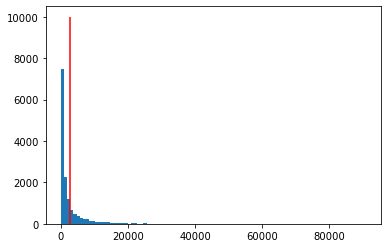

In [ ]:
plt.figure()
plt.vlines(min_area, 0, 10000,'r')
plt.hist(area,100);

min_area

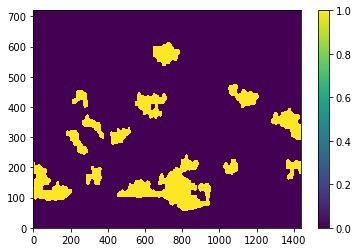

In [ ]:
plt.pcolormesh(ID_area[1,:,:]); plt.colorbar()